In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab

Using TensorFlow backend.


In [0]:
# load cifar10 dataset 
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# reshape (None, 1) -> (None)
y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

# normalization 
x_train, x_test = [(x_train - x_train.max()) / (x_train.max() - x_train.min()),
                   (x_test - x_test.max()) / (x_test.max() - x_test.min())]

# N class
n_classes = 10
print('image shape : {}, label shape : {} '.format(x_train.shape, y_train.shape))
print('image shape : {}, label shape : {} '.format(x_test.shape, y_test.shape))
print('train minimun : {}, train_maximum : {} '.format(x_train.min(), x_train.max()))
print('tests minimun : {}, test_maximum : {} '.format(x_test.min(), x_test.max()))

image shape : (50000, 32, 32, 3), label shape : (50000,) 
image shape : (10000, 32, 32, 3), label shape : (10000,) 
train minimun : 0.0, train_maximum : 1.0 
tests minimun : 0.0, test_maximum : 1.0 


In [4]:
temp = x_train
ratio = int(len(x_train) * 0.7)
ratio_end = int(len(x_train) * 1.0)

x_train = temp[0:ratio, :, :, :]
x_validation = temp[ratio:ratio_end , :, :, :]

y_train_label = y_train[0:ratio]
y_validation_label = y_train[ratio:ratio_end ]

print(y_train_label[:10]) # label이 one_hot encoding상태가 아니다.

print(x_train.shape, y_train_label.shape)
print(x_validation.shape, y_validation_label.shape)

[6 9 9 4 1 1 2 7 8 3]
(35000, 32, 32, 3) (35000,)
(15000, 32, 32, 3) (15000,)


## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size:
                              (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Model A : Build

In [7]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') # 32*32 = 1024
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    
    with tf.name_scope('convolution_layer_1') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 3, 16], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([16])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(xs, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias
        layer = tf.nn.relu(layer)
        
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)

    with tf.name_scope('convolution_layer_2') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[2, 2, 16, 32], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([32])
        bias = tf.Variable(bias_init, name='bias')
    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias    
        layer = layer + bias
        layer = tf.nn.relu(layer)
          
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)
        
            
    with tf.name_scope('convolution_layer_3') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[3, 3, 32, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel= tf.Variable(kernel_init, name='kernel')               
        bias_init = tf.zeros([64])
        bias = tf.Variable(bias_init, name='bias')    
        layer = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer = layer + bias
        layer = tf.nn.relu(layer)

        kernel_init2 = tf.random.normal(shape=[3, 3, 64, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') # random normal 
        kernel2= tf.Variable(kernel_init2, name='kernel')               
        bias_init2 = tf.zeros([64])
        bias2 = tf.Variable(bias_init2, name='bias')    
        layer = tf.nn.conv2d(layer, kernel2, strides=[1,1,1,1], padding='SAME') # convolution and add bias      
        layer = layer + bias2
        layer = tf.nn.relu(layer)
    
        pool = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)        
        
    # receptive filed = 27, images size = 32, output imagesize = (4, 4)

    with tf.name_scope('Reconstruct') : 
        flatten = tf.layers.flatten(pool)
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(flatten) # 32*32
        layer = tf.layers.Dense(1024, activation=tf.nn.relu)(layer)
        y_pred = tf.layers.Dense(10, activation=None, name='y_pred')(layer)
        
    with tf.name_scope('Loss') :
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        print(loss.shape)
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct = tf.equal(pred, ys)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)

W0616 14:00:34.641945 140600144975744 deprecation.py:323] From <ipython-input-7-2d4c5938a597>:54: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0616 14:00:34.862786 140600144975744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 14:00:35.194808 140600144975744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the

()


## Model A : Train

In [8]:
with graph.as_default() :
    
    # 텐서보드에 연결합니다. # sess.run보다 먼저 선언해야함. 
    log_dir = "./log/vgg_net"    
    tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Step2 : 기록
    saver = tf.train.Saver()
    
    # Training
    batch_size = 50
    n_epoch = 30
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.0001
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    minimum_loss = 1.1
    for i in tqdm(range(n_epoch)) :
        for step in range(n_step) :
            batch_xs, batch_ys = next(train_generator)
            _, train_loss_, tbs_train_ = sess.run([train_op, rmse, merged_all], feed_dict = { xs: batch_xs, 
                                                                                              ys: batch_ys, 
                                                                                              lr: learing_rate})
            train_writer.add_summary(tbs_train_, global_step=cnt) # 흠 되야 하는데 안된다.
            cnt += 1
            train_loss.append(train_loss_)
            
            # check validation set
            if step % 100 == 0 :
                loss_, acc_ = sess.run([rmse, accuracy], feed_dict = { xs: x_validation, 
                                                                       ys: y_validation_label})
                valid_loss.append(loss_)
                valid_acc.append(acc_)
                
                # Save the model
                if loss_ < minimum_loss :
                    print("log current model!")
                    minimum_loss = loss_
                    saver.save(sess, save_path='./model/vgg_net')
        print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    
    train_writer.flush() # file을 disk에 쓴다

Wait for 8 seconds...
TensorBoard link:
https://479415ea.ngrok.io


  3%|▎         | 1/30 [00:10<05:01, 10.40s/it]

loss = 1.2565, acc = 42.69%


  7%|▋         | 2/30 [00:15<04:07,  8.83s/it]

loss = 1.1976, acc = 48.52%


 10%|█         | 3/30 [00:20<03:28,  7.71s/it]

loss = 1.1452, acc = 52.70%


 13%|█▎        | 4/30 [00:25<03:01,  6.97s/it]

loss = 1.1192, acc = 55.44%
log current model!
log current model!
log current model!


 17%|█▋        | 5/30 [00:31<02:44,  6.58s/it]

loss = 1.0921, acc = 57.75%
log current model!


 20%|██        | 6/30 [00:37<02:31,  6.31s/it]

loss = 1.0825, acc = 58.42%
log current model!
log current model!


 23%|██▎       | 7/30 [00:43<02:21,  6.17s/it]

loss = 1.0704, acc = 59.93%
log current model!
log current model!
log current model!


 27%|██▋       | 8/30 [00:48<02:12,  6.04s/it]

loss = 1.0534, acc = 60.75%
log current model!


 30%|███       | 9/30 [00:54<02:03,  5.88s/it]

loss = 1.0537, acc = 61.09%


 33%|███▎      | 10/30 [00:59<01:54,  5.74s/it]

loss = 1.0485, acc = 61.20%
log current model!


 37%|███▋      | 11/30 [01:05<01:48,  5.69s/it]

loss = 1.0434, acc = 61.94%
log current model!


 40%|████      | 12/30 [01:10<01:41,  5.66s/it]

loss = 1.0436, acc = 62.31%
log current model!


 43%|████▎     | 13/30 [01:16<01:35,  5.63s/it]

loss = 1.0358, acc = 63.16%
log current model!


 47%|████▋     | 14/30 [01:22<01:29,  5.61s/it]

loss = 1.0325, acc = 63.75%


 50%|█████     | 15/30 [01:27<01:23,  5.55s/it]

loss = 1.0295, acc = 64.43%


 53%|█████▎    | 16/30 [01:32<01:17,  5.53s/it]

loss = 1.0436, acc = 64.15%


 57%|█████▋    | 17/30 [01:38<01:11,  5.50s/it]

loss = 1.0498, acc = 64.55%


 60%|██████    | 18/30 [01:43<01:05,  5.49s/it]

loss = 1.0543, acc = 64.92%


 63%|██████▎   | 19/30 [01:49<01:00,  5.47s/it]

loss = 1.0748, acc = 64.11%


 67%|██████▋   | 20/30 [01:54<00:54,  5.48s/it]

loss = 1.1024, acc = 63.65%


 70%|███████   | 21/30 [02:00<00:49,  5.49s/it]

loss = 1.0950, acc = 64.87%


 73%|███████▎  | 22/30 [02:05<00:43,  5.48s/it]

loss = 1.1292, acc = 64.07%


 77%|███████▋  | 23/30 [02:11<00:38,  5.47s/it]

loss = 1.1421, acc = 64.40%


 80%|████████  | 24/30 [02:16<00:32,  5.46s/it]

loss = 1.1830, acc = 63.84%


 83%|████████▎ | 25/30 [02:22<00:27,  5.47s/it]

loss = 1.2131, acc = 64.44%


 87%|████████▋ | 26/30 [02:27<00:22,  5.52s/it]

loss = 1.2333, acc = 64.39%


 90%|█████████ | 27/30 [02:33<00:16,  5.54s/it]

loss = 1.2738, acc = 63.19%


 93%|█████████▎| 28/30 [02:38<00:11,  5.52s/it]

loss = 1.2771, acc = 64.13%


 97%|█████████▋| 29/30 [02:44<00:05,  5.51s/it]

loss = 1.3152, acc = 63.82%


100%|██████████| 30/30 [02:49<00:00,  5.50s/it]

loss = 1.3438, acc = 63.83%
loss = 1.3438, acc = 63.83%


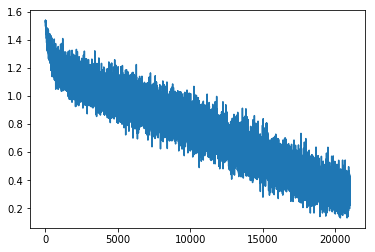

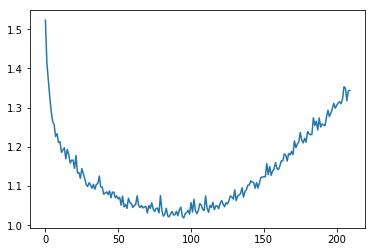

In [9]:
plt.plot(np.arange(0, len(train_loss), 1), train_loss)
plt.show()
plt.plot(np.arange(0, len(valid_loss), 1), valid_loss)
plt.show() # train과 validation 모두 봐야 한다.